In [1]:
%config InlineBackend.figure_format = "svg"


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import LineCollection


In [3]:
import sys
import pathlib
import os
sys.path.append(str(pathlib.Path(os.path.abspath('')).resolve().parent.parent))
from IPython.display import display, HTML

from _9_Mechanics.Spiral import Spiral
from _9_Mechanics.Tribology import Tribology

TB = Tribology()


In [25]:
R = 6.35 / 2
Rg = R * 1.08
dR = R * 0.08 / np.sqrt(2)
PCR = 20.875
l = 10.0

SP1 = Spiral(alp=np.deg2rad(1e-1), l=l, r=PCR, eta=np.array([[-dR, -dR],[-dR, dR]]), R=np.array([Rg, Rg]))
SP2 = Spiral(alp=np.deg2rad(-1e-1), l=l, r=PCR, eta=np.array([[dR, dR],[dR, -dR]]), R=np.array([Rg, Rg]))

rho = 7.9e-3 # [g/mm^3]
Ball_m = 4/3 * np.pi * R**3 * rho # [g]
Ball_I = 2/5 * Ball_m * R**2 # [g * mm^2]
Ball_r_inv = 1.0 / R
zeta = 0.2
E_Reduced = 231e3 # [N/mm^2]
n_slice = 21
rpm = 100
w12 = np.array([[rpm * np.pi / 30, 0.0, 0.0], [0.0, 0.0, 0.0]])
v12 = w12 * l / 2 / np.pi
SliceForceRatio = TB.SliceForceRatio(n_slice)
mu = 0.10


In [26]:
p0 = np.array([[4,0,0], [5,0,0]])
x0 = np.array([2,0,0])
v0 = np.array([0,0,100])
w0 = np.array([0,0,5])

TB.surface_velocity(x0, p0, v0, w0)


array([[  0,  10, 100],
       [  0,  15, 100]])

In [124]:
def vaT_ball(xvw_ball, t, R, SP12, v12, w12, Ball_r_inv, zeta, E_Reduced, n_slice, SliceForceRatio, mu, Ball_m, Ball_I):
    x_ball = xvw_ball[0:3]
    v_ball = xvw_ball[3:6]
    w_ball = xvw_ball[6:9]
    Zeros = np.zeros(3)
    F_sum = Zeros.copy()
    T_sum = Zeros.copy()
    vr = np.linalg.norm(v_ball)

    for iSP, SP in enumerate(SP12):
        for i in range(2):
            cos_sin1, dx1, exyz1 = SP.get_contact(x_ball, R, i)
            if dx1 > 0:
                SP_r_inv = SP.get_rho(cos_sin1[0], i)
                R_Reduced1 = 1.0 / (Ball_r_inv + SP_r_inv)
                k1, a1, b1 = TB.BrewHamrock(R_Reduced1[0], R_Reduced1[1], dx1, E_Reduced)
                v1 = v_ball.dot(exyz1)
                F1_norm = TB.Tsuji(k1, zeta, Ball_m, v1, dx1)
                F1 = - F1_norm * exyz1

                eta1 = SP.to_eta2(x_ball)
                xyz2eta1 = SP.get_xyz2eta(eta1[0])
                b_dir = xyz2eta1.T @ np.array([1.0, 0.0, 0.0])
                a_dir = np.cross(b_dir, exyz1)
                
                peak = x_ball + (R - dx1 / 2) * exyz1
                r_slice = (np.arange(n_slice) - n_slice / 2 + 0.5) / n_slice * 2
                a_slice = a1 * r_slice
                b_slice = b1 * r_slice
                p_slice = peak + a_slice.reshape(-1, 1) @ a_dir.reshape(1, -1) - 0.5 * np.square(a_slice).reshape(-1, 1) / R @ exyz1.reshape(1, -1)
                SP_v = TB.surface_velocity(Zeros, p_slice, v12[iSP], w12[iSP])
                BL_v = TB.surface_velocity(x_ball, p_slice, v_ball, w_ball)
                dv = BL_v - SP_v
                F_slice = F1_norm * SliceForceRatio
                v_dir = dv.T * (1 / np.sqrt(np.square(dv).sum(1)))
                muF = - F_slice * v_dir * mu
                muT = TB.calc_Torque(x_ball, p_slice, muF.T)
                F_sum = F_sum + F1 + muF.sum(1)
                T_sum = T_sum + muT.sum(0)
                                
    a_ball = F_sum / Ball_m
    T_ball = T_sum / Ball_I
    
    return np.concatenate([v_ball, a_ball, T_ball])


In [125]:
x_ball = np.array([0.0, PCR, 0.0])
v_ball = - np.array([ -16.66666666, -1.8005798, -195.28004922]) / 2
w_ball = np.array([-0.69860631, -0.71243783, 0.06619335]) * np.linalg.norm(v_ball) / R
xvw_ball = np.concatenate([x_ball, v_ball, w_ball])


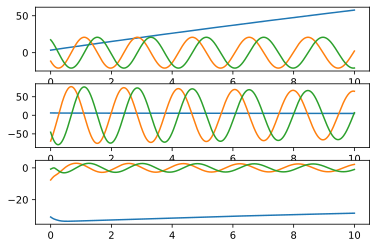

In [129]:
from scipy.integrate import odeint
t = np.linspace(0, 10, 1000)
sol = odeint(vaT_ball, xvw_ball, t, args=(R, [SP1, SP2], v12, w12, Ball_r_inv, zeta, E_Reduced, n_slice, SliceForceRatio, mu, Ball_m, Ball_I))

fig, ax = plt.subplots(3)
ax[0].plot(t[:], sol[:, 0:3])
ax[1].plot(t[:], sol[:, 3:6])
ax[2].plot(t[:], sol[:, 6:9])

plt.show()


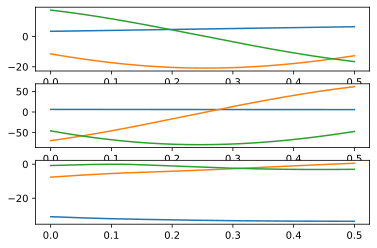

In [127]:
xvw_ball = sol[-1, :]

sol = odeint(vaT_ball, xvw_ball, t, args=(R, [SP1, SP2], v12, w12, Ball_r_inv, zeta, E_Reduced, n_slice, SliceForceRatio, mu, Ball_m, Ball_I))

fig, ax = plt.subplots(3)
ax[0].plot(t[:], sol[:, 0:3])
ax[1].plot(t[:], sol[:, 3:6])
ax[2].plot(t[:], sol[:, 6:9])

plt.show()